In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import util
import importlib
import time
from util import create_snapshot_features
import sys
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
importlib.reload(util)



<module 'util' from '/Users/kolten/optiver/util.py'>

In [2]:

start_time_1 = time.time()
# Load and combine parquet files
feature_df = pd.read_parquet("order_book_feature.parquet", engine='pyarrow')
target_df = pd.read_parquet("order_book_target.parquet", engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_df = pd.read_csv("time_id_reference.csv")
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_raw = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df_50200 = util.create_snapshot_features(df_raw)

# Step 2: Compute rolling-window training set
rolling_features_df_50200 = util.generate_rolling_features(snapshot_features_df_50200)

# Merge time_id to datetime (optional for plotting/debugging)
rolling_features_df_50200 = pd.merge(
    rolling_features_df_50200.drop(columns=["datetime"], errors="ignore"),
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
# Preview
print("Rolling features:", rolling_features_df_50200.shape)

print("Rolling features:", snapshot_features_df_50200.shape)

Rolling features: (833290, 25)
Rolling features: (4166788, 22)


# part1

In [ ]:
MODEL_PATH_3 = "moe_full.h5"
SCALER_PATH_3 =  "moe_scalers_full.pkl"

with open(SCALER_PATH_3, 'rb') as f:
    config = pickle.load(f)
model = load_model(MODEL_PATH_3, compile=False)
end_time_1 = time.time()

## Feature Engineering

In [4]:

start_time_2 = time.time()

seq_df = util.generate_tick_sequences(
    snapshot_features_df_50200,
    feature_cols=[
        "wap", "spread_pct", "log_return", "depth_ratio", "imbalance",
        "mid_price", "bid_ask_spread", "log_wap_change", "rolling_std_logret"
    ],
    window=config.get('window', util.WINDOW_SIZE),
    horizon=config.get('horizon', util.FORECAST_HORIZON),
    step=config.get('step', util.STEP)
)

subset = seq_df.iloc[-len(seq_df) // 8:]  
X = np.stack(subset['X'].values)         # shape: (n_samples, window, n_features)
y_true = subset['y'].values              # shape: (n_samples,)

n_samples, window, n_feats = X.shape
X_scaled = config['x_scaler'].transform(X.reshape(-1, n_feats)).reshape(n_samples, window, n_feats)
y_scaled = config['y_scaler'].transform(y_true.reshape(-1, 1)).flatten()

end_time_2 = time.time()

## model test

In [5]:
start_time_3 = time.time()

y_pred_scaled = model.predict(X_scaled)           # shape: (2, 94421, 1)
y_pred_scaled = np.mean(y_pred_scaled, axis=0)    # shape: (94421, 1)
y_pred_2 = config['y_scaler'].inverse_transform(y_pred_scaled).flatten()

#merge snapshot_features_df and get bas
snapshot_subset = pd.merge(
    subset[['time_id', 'start_time']],
    snapshot_features_df_50200[['time_id', 'seconds_in_bucket', 'bid_ask_spread']],
    left_on=['time_id', 'start_time'],
    right_on=['time_id', 'seconds_in_bucket'],
    how='left'
)

results_df = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time': subset['start_time'].values,
    'y_true_2': subset['y'].values,
    'y_pred_2': y_pred_2,
    'bid_ask_spread': snapshot_subset['bid_ask_spread'].values  # add bas
})


#from DataFrame
y_true_2 = results_df['y_true_2'].values

mse = mean_squared_error(y_true_2, y_pred_2)
qlike = np.mean((y_true_2 - y_pred_2) ** 2 / (y_true_2 ** 2))

print(f"Performance:")
print(f"  • MSE   = {mse:.6e}")
print(f"  • QLIKE = {qlike:.6e}")


end_time_3 = time.time()


2951/2951 ━━━━━━━━━━━━━━━━━━━━ 116s 39ms/step
Performance:
  • MSE   = 3.645829e-08
  • QLIKE = 2.261663e+01


## Time

In [9]:
end_time_4 = time.time()

print(f"Model and Feature Loading Phase time: {end_time_1 - start_time_1:.2f} seconds")
print(f"Feature Engineering: {end_time_2 - start_time_2:.2f} seconds")
print(f"model run time: {end_time_3 - start_time_3:.2f} seconds")
print(f"average of every sample run time: {(end_time_3 - start_time_3)/4176:.6f} seconds")



Model and Feature Loading Phase time: 254.42 seconds
Feature Engineering: 118.21 seconds
model run time: 117.19 seconds
average of every sample run time: 0.028064 seconds


# part2 - BAS

## XGboost model for 50200

define a function of build_spread_features(), perpare for the future work in different stock

In [10]:
start_time_a = time.time()
start_time_c = time.time()
def build_spread_features(results_df):

    # Step 1: lag features
    results_df = results_df.sort_values(by=['time_id', 'start_time'])

    results_df['spread_lag1'] = results_df['bid_ask_spread'].shift(1)
    results_df['spread_lag2'] = results_df['bid_ask_spread'].shift(2)
    results_df['vol_pred_lag1'] = results_df['y_pred_2'].shift(1)

    results_df['spread_roll_mean_5'] = results_df.groupby('time_id')['bid_ask_spread'].transform(lambda x: x.rolling(5).mean())
    results_df['spread_roll_std_5'] = results_df.groupby('time_id')['bid_ask_spread'].transform(lambda x: x.rolling(5).std())

    # Step 2:  future +1 spread
    results_df['spread_t_plus_1'] = results_df['bid_ask_spread'].shift(-1)

    # delete NA
    results_df = results_df.dropna(subset=[
        'spread_lag1', 'spread_lag2', 'vol_pred_lag1',
        'spread_roll_mean_5', 'spread_roll_std_5', 'spread_t_plus_1'
    ])

    # create X and y
    X_bas = results_df[[
        'y_pred_2',
        'vol_pred_lag1',
        'spread_lag1',
        'spread_lag2',
        'spread_roll_mean_5',
        'spread_roll_std_5'
    ]]

    y_bas = results_df['spread_t_plus_1']
    
    return X_bas, y_bas

In [11]:

X_bas, y_bas = build_spread_features(results_df)

X_train, X_test, y_train, y_test = train_test_split(
    X_bas, y_bas, test_size=0.2, random_state=42
)

model_bas = XGBRegressor()
model_bas.fit(X_train, y_train)

y_pred_bas = model_bas.predict(X_test)
mse_bas = mean_squared_error(y_test, y_pred_bas)

qlike= np.mean((y_test - y_pred_bas) ** 2 / (y_test ** 2))

print(f"MSE:{mse_bas:.6e}")

print(f"qlike:{qlike:.6e}")


MSE:1.724728e-05
qlike:7.704452e-02


In [12]:

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f" best turn: {grid_search.best_params_}")
print(f" minimum MSE: {-grid_search.best_score_:.6e}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
 best turn: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
 minimum MSE: 1.753768e-05


In [13]:
model_bas = XGBRegressor(
    n_estimators=300,       
    max_depth=4,            
    learning_rate=0.01,     
    subsample=0.8,          
    colsample_bytree=1.0,   
    random_state=3888,        

)
model_bas.fit(X_train, y_train)

y_pred_bas = model_bas.predict(X_test)

results_df.loc[X_bas.index, 'y_pred_bas'] = model_bas.predict(X_bas)

results_df = results_df.dropna(subset=[ 'y_pred_bas' ])
mse_bas = mean_squared_error(y_test, y_pred_bas)

qlike= np.mean((y_test - y_pred_bas) ** 2 / (y_test ** 2))

print(f"MSE:{mse_bas:.6e}")

print(f"qlike:{qlike:.6e}")

end_time_a =time.time()

MSE:1.721950e-05
qlike:7.660237e-02


## XGboost model for 104919

In [14]:
start_time_b =  time.time()

# Load and combine parquet files
feature_df = pd.read_parquet("order_book_feature.parquet", engine='pyarrow')
target_df = pd.read_parquet("order_book_target.parquet", engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_df = pd.read_csv("time_id_reference.csv")
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_raw = combined_df[combined_df["stock_id"] == 104919].copy()

# Step 1: Compute snapshot features
snapshot_features_df_104919 = util.create_snapshot_features(df_raw)



Use the y output from part 1 to predict bas, aligning the time first.

In [15]:

df_pred_50200 = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time': subset['start_time'].values,
    'y_pred_2': y_pred_2
})

merged_df = pd.merge(
    snapshot_features_df_104919,
    df_pred_50200,
    left_on=['time_id', 'seconds_in_bucket'],
    right_on=['time_id', 'start_time'],
    how='inner'
)

snapshot_subset = snapshot_features_df_104919[[
    'time_id', 'seconds_in_bucket', 'bid_ask_spread'
]]

results_df_2 = pd.merge(
    snapshot_subset,
    df_pred_50200,
    left_on=['time_id', 'seconds_in_bucket'],
    right_on=['time_id', 'start_time'],
    how='inner'
)



In [16]:

X_bas, y_bas = build_spread_features(results_df_2)

X_train, X_test, y_train, y_test = train_test_split(X_bas, y_bas, test_size=0.2, random_state=42)

model_bas = XGBRegressor(
    n_estimators=100,       
    max_depth=4,            
    learning_rate=0.05,     
    subsample=0.8,          
    colsample_bytree=1.0,   
    random_state=3888,        

)
model_bas.fit(X_train, y_train)

y_pred_bas = model_bas.predict(X_test)
mse_bas = mean_squared_error(y_test, y_pred_bas)

qlike= np.mean((y_test - y_pred_bas) ** 2 / (y_test ** 2))

print(f"MSE:{mse_bas:.6e}")

print(f"qlike:{qlike:.6e}")
end_time_b =  time.time()

MSE:2.152719e-05
qlike:1.062894e-01


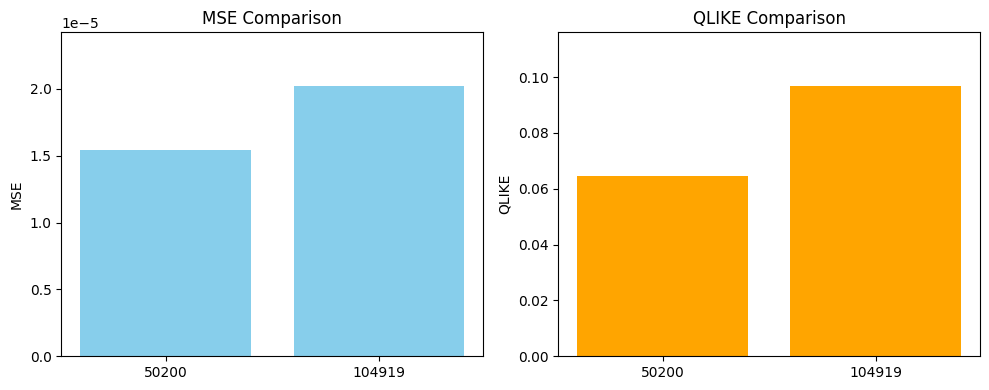

In [17]:
import matplotlib.pyplot as plt

labels = ['50200', '104919']

mse_values = [1.54e-05, 2.02e-05]
qlike_values = [6.45e-02, 9.67e-02]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.bar(labels, mse_values, color='skyblue')
ax1.set_title('MSE Comparison')
ax1.set_ylabel('MSE')
ax1.set_ylim(0, max(mse_values) * 1.2) 

ax2.bar(labels, qlike_values, color='orange')
ax2.set_title('QLIKE Comparison')
ax2.set_ylabel('QLIKE')
ax2.set_ylim(0, max(qlike_values) * 1.2)

plt.tight_layout()
plt.show()

end_time_c = time.time()


## Time

In [18]:

print(f"XGboost model for 50200: {end_time_a - start_time_a:.2f} seconds")
print(f"XGboost model for 104919: {(end_time_b - start_time_b)/4176:.6f} seconds")
print(f"Total computation time: {end_time_c - start_time_c:.2f} seconds")

XGboost model for 50200: 233.43 seconds
XGboost model for 104919: 0.012201 seconds
Total computation time: 289.25 seconds


# Quoting Price

In [19]:
results_df['mid_price'] = 100 + np.random.normal(0, 0.02, len(results_df))

y_scaled = (results_df['y_pred_bas'] - results_df['y_pred_bas'].mean()) / results_df['y_pred_bas'].std()
results_df['alpha'] = 1.0 + 0.1 * y_scaled.clip(-0.5, 0.5)


results_df['quoted_bid'] = results_df['mid_price'] - results_df['alpha'] * results_df['y_pred_bas'] / 2
results_df['quoted_ask'] = results_df['mid_price'] + results_df['alpha'] * results_df['y_pred_bas'] / 2
results_df['real_bid'] = results_df['mid_price'] - results_df['bid_ask_spread'] / 2
results_df['real_ask'] = results_df['mid_price'] + results_df['bid_ask_spread'] / 2



By standardizing the predicted values, we convert them into a measure of volatility intensity relative to the average level (y_scaled). This volatility signal is then used to construct an adjustment factor alpha, which is clipped within a reasonable range (from -1 to 1). The alpha is ultimately applied to the quoting calculation, allowing the strategy to widen the quote range during periods of high market volatility and narrow it during calmer periods—enabling a more adaptive and risk-aware quoting approach.

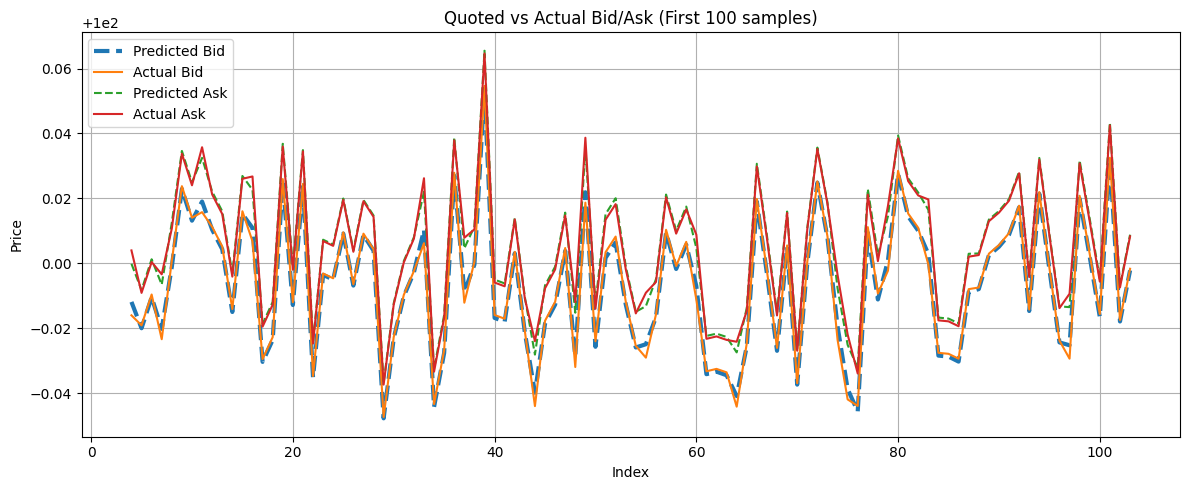

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(results_df['quoted_bid'][:100], label='Predicted Bid', linestyle='--',linewidth=3,)
plt.plot(results_df['real_bid'][:100], label='Actual Bid', linestyle='-')
plt.plot(results_df['quoted_ask'][:100], label='Predicted Ask', linestyle='--')
plt.plot(results_df['real_ask'][:100], label='Actual Ask', linestyle='-')
plt.title("Quoted vs Actual Bid/Ask (First 100 samples)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
results_df[['quoted_bid', 'real_ask', 'quoted_ask', 'real_bid','y_pred_bas','mid_price']].head(10)


,quoted_bid,real_ask,quoted_ask,real_bid,y_pred_bas,mid_price
4,99.988111,100.003980,99.999848,99.983980,0.012120,99.993980
5,99.980002,99.990894,99.991786,99.980894,0.012141,99.985894
6,99.989539,100.000394,100.001249,99.990394,0.012108,99.995394
7,99.979800,99.996614,99.993429,99.976614,0.012980,99.986614
8,99.998910,100.010715,100.012520,100.000715,0.012962,100.005715
9,100.022917,100.033773,100.034628,100.023773,0.012108,100.028773
10,100.013144,100.024040,100.024936,100.014040,0.012145,100.019040
11,100.019039,100.035767,100.032494,100.015767,0.012867,100.025767
12,100.010362,100.021232,100.022101,100.011232,0.012121,100.016232
13,100.004341,100.015193,100.016044,100.005193,0.012105,100.010193
